# 1. CBoW demo (Short text)

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (29/08/2023)

Ths notebook demonstrates how we may design and train a CBoW architecture, on a very simple corpus of text. The dataset is not large enough to produce a good language model, but we do not expect students to be able to run it on a massive dataset, for computational costs reasons.

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.2)
- Numpy (tested on v1.25.2)
- Torch (tested on v2.0.1+cu118)
- We also strongly recommend setting up CUDA on your machine!

### Imports

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

### Step 1. Produce some data based on a given text for training our CBoW model

Our task here is twofold:
- We will read the text in the short_text.txt file and find the dictionary V, corresponding to the words present in text. 
- We will use the procedure detailed in the slides to generate data points from the text in the short_text.txt file.

In [2]:
def text_to_train(text, context_window):
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        context = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        target = text[i]
        data.append((context, target))
        
    return data

In [3]:
def create_text():
    
    # Load corpus from file
    with open("./text_short.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [4]:
text = create_text()
print(text)

['i', 'would', 'be', 'fatal', 'for', 'the', 'nation', 'to', 'overlook', 'the', 'urgency', 'of', 'the', 'moment', 'and', 'to', 'underestimate', 'the', 'determination', 'of', 'its', 'colored', 'citizens', 'this', 'sweltering', 'summer', 'of', 'the', 'colored', 'peoples', 'legitimate', 'discontent', 'will', 'not', 'pass', 'until', 'there', 'is', 'an', 'invigorating', 'autumn', 'of', 'freedom', 'and', 'equality', 'nineteen', 'sixtythree', 'is', 'not', 'an', 'end', 'but', 'a', 'beginning', 'those', 'who', 'hope', 'that', 'the', 'colored', 'americans', 'needed', 'to', 'blow', 'off', 'steam', 'and', 'will', 'now', 'be', 'content', 'will', 'have', 'a', 'rude', 'awakening', 'if', 'the', 'nation', 'returns', 'to', 'business', 'as', 'usual', 'there', 'will', 'be', 'neither', 'rest', 'nor', 'tranquility', 'in', 'america', 'until', 'the', 'colored', 'citizen', 'is', 'granted', 'his', 'citizenship', 'rights', 'the', 'whirlwinds', 'of', 'revolt', 'will', 'continue', 'to', 'shake', 'the', 'foundations

In [5]:
def generate_data(text, context_window):
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [6]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

We can see the vocabulary/dictionary of words that are present in the original text.

In [7]:
print(vocab)

{'urgency', 'down', 'come', 'your', 'together', 'citizenship', 'persons', 'will', 'been', 'moment', 'slaveowners', 'meaning', 'stating', 'mobility', 'basic', 'you', 'pass', 'friends', 'they', 'those', 'justice', 'fatal', 'suffering', 'equality', 'back', 'which', 'emerges', 'fatigue', 'satisfied', 'lodging', 'dignity', 'these', 'like', 'now', 'storms', 'an', 'four', 'nineteen', 'rude', 'autumn', 'today', 'veterans', 'citizens', 'modern', 'stream', 'rolls', 'believes', 'overlook', 'battered', 'south', 'ghettos', 'true', 'have', 'long', 'former', 'deeply', 'freedom', 'character', 'ghetto', 'redemptive', 'a', 'americans', 'whirlwinds', 'has', 'selfhood', 'tribulations', 'tomorrow', 'its', 'blow', 'york', 'equal', 'knowing', 'we', 'is', 'american', 'and', 'nation', 'until', 'colored', 'that', 'if', 'but', 'mississippi', 'revolt', 'america', 'georgia', 'brutality', 'invigorating', 'men', 'waters', 'granted', 'legitimate', 'alabama', 'in', 'to', 'can', 'able', 'little', 'where', 'even', 'left

In [8]:
print(word2index)

{'urgency': 0, 'down': 1, 'come': 2, 'your': 3, 'together': 4, 'citizenship': 5, 'persons': 6, 'will': 7, 'been': 8, 'moment': 9, 'slaveowners': 10, 'meaning': 11, 'stating': 12, 'mobility': 13, 'basic': 14, 'you': 15, 'pass': 16, 'friends': 17, 'they': 18, 'those': 19, 'justice': 20, 'fatal': 21, 'suffering': 22, 'equality': 23, 'back': 24, 'which': 25, 'emerges': 26, 'fatigue': 27, 'satisfied': 28, 'lodging': 29, 'dignity': 30, 'these': 31, 'like': 32, 'now': 33, 'storms': 34, 'an': 35, 'four': 36, 'nineteen': 37, 'rude': 38, 'autumn': 39, 'today': 40, 'veterans': 41, 'citizens': 42, 'modern': 43, 'stream': 44, 'rolls': 45, 'believes': 46, 'overlook': 47, 'battered': 48, 'south': 49, 'ghettos': 50, 'true': 51, 'have': 52, 'long': 53, 'former': 54, 'deeply': 55, 'freedom': 56, 'character': 57, 'ghetto': 58, 'redemptive': 59, 'a': 60, 'americans': 61, 'whirlwinds': 62, 'has': 63, 'selfhood': 64, 'tribulations': 65, 'tomorrow': 66, 'its': 67, 'blow': 68, 'york': 69, 'equal': 70, 'knowin

In [9]:
print(index2word)

{0: 'urgency', 1: 'down', 2: 'come', 3: 'your', 4: 'together', 5: 'citizenship', 6: 'persons', 7: 'will', 8: 'been', 9: 'moment', 10: 'slaveowners', 11: 'meaning', 12: 'stating', 13: 'mobility', 14: 'basic', 15: 'you', 16: 'pass', 17: 'friends', 18: 'they', 19: 'those', 20: 'justice', 21: 'fatal', 22: 'suffering', 23: 'equality', 24: 'back', 25: 'which', 26: 'emerges', 27: 'fatigue', 28: 'satisfied', 29: 'lodging', 30: 'dignity', 31: 'these', 32: 'like', 33: 'now', 34: 'storms', 35: 'an', 36: 'four', 37: 'nineteen', 38: 'rude', 39: 'autumn', 40: 'today', 41: 'veterans', 42: 'citizens', 43: 'modern', 44: 'stream', 45: 'rolls', 46: 'believes', 47: 'overlook', 48: 'battered', 49: 'south', 50: 'ghettos', 51: 'true', 52: 'have', 53: 'long', 54: 'former', 55: 'deeply', 56: 'freedom', 57: 'character', 58: 'ghetto', 59: 'redemptive', 60: 'a', 61: 'americans', 62: 'whirlwinds', 63: 'has', 64: 'selfhood', 65: 'tribulations', 66: 'tomorrow', 67: 'its', 68: 'blow', 69: 'york', 70: 'equal', 71: 'kn

We can also visualize the dataset, below which looks as expected.

In [10]:
print(data)

[(['i', 'would', 'fatal', 'for'], 'be'), (['would', 'be', 'for', 'the'], 'fatal'), (['be', 'fatal', 'the', 'nation'], 'for'), (['fatal', 'for', 'nation', 'to'], 'the'), (['for', 'the', 'to', 'overlook'], 'nation'), (['the', 'nation', 'overlook', 'the'], 'to'), (['nation', 'to', 'the', 'urgency'], 'overlook'), (['to', 'overlook', 'urgency', 'of'], 'the'), (['overlook', 'the', 'of', 'the'], 'urgency'), (['the', 'urgency', 'the', 'moment'], 'of'), (['urgency', 'of', 'moment', 'and'], 'the'), (['of', 'the', 'and', 'to'], 'moment'), (['the', 'moment', 'to', 'underestimate'], 'and'), (['moment', 'and', 'underestimate', 'the'], 'to'), (['and', 'to', 'the', 'determination'], 'underestimate'), (['to', 'underestimate', 'determination', 'of'], 'the'), (['underestimate', 'the', 'of', 'its'], 'determination'), (['the', 'determination', 'its', 'colored'], 'of'), (['determination', 'of', 'colored', 'citizens'], 'its'), (['of', 'its', 'citizens', 'this'], 'colored'), (['its', 'colored', 'this', 'swelt

This last function is a helper function that will allow us to rapidly convert words into tensors.

In [11]:
def words_to_tensor(words: list, w2i: dict, dtype = torch.FloatTensor):
    tensor =  dtype([w2i[word] for word in words])
    tensor = tensor.to(device)
    return Variable(tensor)

### Step 2. Create a CBoW model and train

Our CBoW model will consist of a simple Embedding layer, a summation aggregating the context of the words in the sentence, and a Linear layer predicting the missing word.

In [12]:
class CBOW(nn.Module):

    def __init__(self, context_size, embedding_size, vocab_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim = 0)
        out = self.linear(embeds)
        #out = F.log_softmax(out, dim = -1)
        return out

In [13]:
# Create model and pass to CUDA
model = CBOW(context_size = 2, embedding_size = 20, vocab_size = len(vocab))
model = model.to(device)
model.train()

CBOW(
  (embeddings): Embedding(236, 20)
  (linear): Linear(in_features=20, out_features=236, bias=True)
)

We will then train the model as before approaching the task of predicting the missing word as a multi-class classification task.

In [14]:
# Define training parameters
learning_rate = 0.001
epochs = 500
torch.manual_seed(28)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

Some helpers functions below, before we define our trainer function.

In [15]:
def get_prediction(context, model, word2index, index2word):
    
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # Reshape to cover for absence of minibatches (needed for loss function)
    prediction = torch.reshape(prediction, (1, 236))
    _, index = torch.max(prediction, 1)
    
    return index2word[index.item()]

In [16]:
def check_accuracy(model, data, word2index, index2word):
    
    # Compute accuracy
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)
        if prediction == target:
            correct += 1
            
    return correct/len(data)

In [17]:
losses = []
accuracies = []

for epoch in range(epochs):
    total_loss = 0
    
    for context, target in data:
        
        # Prepare data
        ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
        target = words_to_tensor([target], word2index, dtype = torch.LongTensor)
        
        # Forward pass
        model.zero_grad()
        output = model(ids)
        # Reshape to cover for absence of minibatches (needed for loss function)
        output = torch.reshape(output, (1, 236))
        loss = loss_func(output, target)
        
        # Backward pass and optim
        loss.backward()
        optimizer.step()
        
        # Loss update
        total_loss += loss.data.item()
    
    # Display
    if epoch % 10 == 0:
        accuracy = check_accuracy(model, data, word2index, index2word)
        print("Accuracy after epoch {} is {}".format(epoch, accuracy))
        accuracies.append(accuracy)
        losses.append(total_loss)

Accuracy after epoch 0 is 0.0018867924528301887
Accuracy after epoch 10 is 0.17169811320754716
Accuracy after epoch 20 is 0.2528301886792453
Accuracy after epoch 30 is 0.27735849056603773
Accuracy after epoch 40 is 0.31886792452830187
Accuracy after epoch 50 is 0.35660377358490564
Accuracy after epoch 60 is 0.4056603773584906
Accuracy after epoch 70 is 0.46037735849056605
Accuracy after epoch 80 is 0.530188679245283
Accuracy after epoch 90 is 0.5641509433962264
Accuracy after epoch 100 is 0.6075471698113207
Accuracy after epoch 110 is 0.6339622641509434
Accuracy after epoch 120 is 0.6660377358490566
Accuracy after epoch 130 is 0.7
Accuracy after epoch 140 is 0.730188679245283
Accuracy after epoch 150 is 0.7415094339622641
Accuracy after epoch 160 is 0.7584905660377359
Accuracy after epoch 170 is 0.7773584905660378
Accuracy after epoch 180 is 0.7924528301886793
Accuracy after epoch 190 is 0.8037735849056604
Accuracy after epoch 200 is 0.8264150943396227
Accuracy after epoch 210 is 0.839

### 3. Visualization

The model trains nicely and seems very capable at predicting the missing word in each context of 2k words.

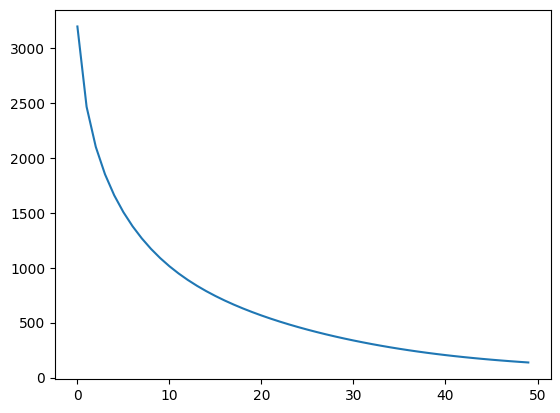

In [18]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

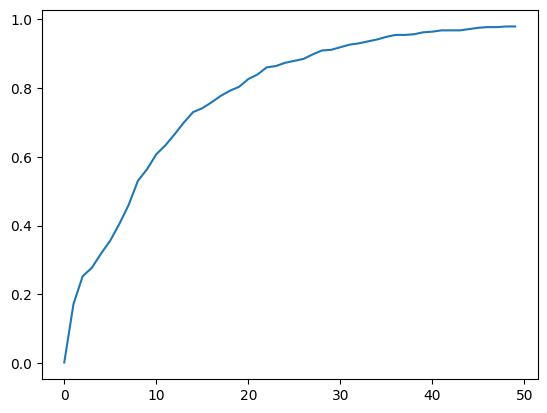

In [19]:
# Display accuracy over time
plt.figure()
plt.plot(accuracies)
plt.show()

We can later on, extract the embedding layer and visualize the word embedding for any word in the vocabulary.

This embedding layer could then be reused for other NLP tasks.

In [20]:
word1 = words_to_tensor(["americans"], word2index, dtype = torch.LongTensor)
word2 = words_to_tensor(["citizens"], word2index, dtype = torch.LongTensor)
word3 = words_to_tensor(["carolina"], word2index, dtype = torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
print(w1)
print(w2)
print(w3)

tensor([ 1.0422,  0.4315,  0.3469,  0.5487, -0.3045, -0.3975, -1.9397,  0.3174,
         0.1760,  0.0712,  0.4417, -1.2630, -0.8395,  0.1130,  0.0573,  0.5997,
        -1.2630, -0.4994,  1.7413, -0.2182], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([ 0.5541, -1.5371, -0.5007,  0.4386, -0.5770, -0.5330,  0.6207, -1.2229,
        -0.7525, -1.2030, -1.3367,  1.4306, -0.7401, -1.1309,  0.1265,  0.0560,
         1.2429, -0.8027,  0.8652, -0.6612], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([-1.9887, -1.9659, -1.9231, -1.5314,  0.4499,  0.9343, -0.4531, -0.3294,
         0.8052,  1.1817,  0.1699,  0.4783, -0.9813, -0.8512,  0.2793, -0.1641,
        -0.0837, -1.6092,  0.1099,  1.0694], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
